# Vive Pro Eye Evaluation - Preprocessing & Demographic Data

This notebook imports raw gaze data, applies preprocessing and outlier filtering, then recreates the following results from the manuscript.

**Results reproduced:**
- Participant demographics,
- Supplementary Table S1: Overall eye tracking metrics per participant,
- Figure 2: Repeated sample statistics, and 
- Figure 3: Accuracy histograms (histograms are based on all data before outlier correction) and distribution metrics with and without outlier correction.

**Dataset names:**
- *tar_raw:* All target fixations without any outlier correction
- *tar:* Valid target fixations after outlier correction (exported to *gaze_targets.pkl*, *data_targets_all.csv*)
- *tar_i10/tar_raw_i10:* As above, but limited to targets presented in the inner 20° range (Vive Pro Eye specs) (tar_i10 exported *gaze_targets_i10.pkl*, *data_targets_inner.csv*)
- *val:* Metrics aggregated across targets for each measurement session, one validation session per row (exported to *gaze_validations.pkl*, *data_validations.csv*)
- *sam*: All gaze sample data for each session (90 Hz sample rate) (exported to *gaze_samples.pkl*)
- *pp:* Metrics aggregated for each participant, i.e. across measurement sessions (exported to *participants.pkl*, *participants.csv*)
- *pt:* Subset of 'pp' following the columns in supplementary Table S1 (exported to *table1.csv*)


## Data Import

In [1]:
import os
import pickle
import hashlib
import itertools

import numpy as np
import pandas as pd

from scipy.stats import linregress

from analysis import * 

FLOAT_FMT = '%.2f'
FIGTYPES = ['png']

# Outlier threshold for accuracy, in degrees
# alternatively: np.percentile(tar.acc, 99) = 7.09
OUTLIER_ACC = 5.0 


Note: vexptoolbox is not running under Vizard, or Vizard packages could not be imported. Only analysis tools will be available.


In [2]:
# Folders
folder_data = '../data'
folder_tmpdata = '.'
folder_results = '../results'


In [3]:
# Participant vision test results, measured post-hoc (empty/NaN - not measured)
vdata = {1:  {'hmd': 1, 'dom_eye': 'left', 'true_ipd': 60.5, 'setup': 3},
         2:  {'hmd': 2, 'dom_eye': 'left', 'true_ipd': 55, 'setup': 2},
         3:  {'hmd': 2, 'dom_eye': 'right', 'true_ipd': 57.5, 'setup': 1},
         4:  {'hmd': 1, 'dom_eye': 'left', 'true_ipd': 60.5, 'setup': 1},
         5:  {'hmd': 2, 'dom_eye': '', 'true_ipd': np.nan, 'setup': 1},
         6:  {'hmd': 2, 'dom_eye': 'left', 'true_ipd': 62.5, 'setup': 2},
         7:  {'hmd': 1, 'dom_eye': 'right', 'true_ipd': 58.0, 'setup': 3},
         8:  {'hmd': 1, 'dom_eye': 'right', 'true_ipd': 62.5, 'setup': 3},
         9:  {'hmd': 1, 'dom_eye': 'left', 'true_ipd': np.nan, 'setup': 1},
         10: {'hmd': 2, 'dom_eye': '', 'true_ipd': 57.0, 'setup': 3},
         11: {'hmd': 1, 'dom_eye': 'right', 'true_ipd': 69.5, 'setup': 3},
         12: {'hmd': 2, 'dom_eye': 'right', 'true_ipd': 62.0, 'setup': 3},
         13: {'hmd': 2, 'dom_eye': '', 'true_ipd': np.nan, 'setup': 2},
         14: {'hmd': 2, 'dom_eye': '', 'true_ipd': np.nan, 'setup': 2},
         15: {'hmd': 1, 'dom_eye': 'right', 'true_ipd': 70.0, 'setup': 1},
         16: {'hmd': 1, 'dom_eye': 'left', 'true_ipd': 58.5, 'setup': 2},
         17: {'hmd': 2, 'dom_eye': 'right', 'true_ipd': 61.5, 'setup': 1},
         18: {'hmd': 1, 'dom_eye': 'right', 'true_ipd': 61, 'setup': 2}
        }


In [4]:
# Read experiment data files
val, tar, sam = read_json_data(folder_data, show_progress=False, exclude_acc=OUTLIER_ACC)


Importing JSON experiment data files...
Done importing.


In [5]:
# Set user and session numbers to numeric type
val.loc[:, 'session'] = val.loc[:, 'session'].astype('int64')
tar.loc[:, 'session'] = tar.loc[:, 'session'].astype('int64')

val.loc[:, 'user'] = val.loc[:, 'user'].astype('int64')
tar.loc[:, 'user'] = tar.loc[:, 'user'].astype('int64')


## Outlier correction

In [6]:
# Outlier correction: Mark individual fixations where one eye or combined gaze has no valid data
tar.loc[:, 'outlier_reason'] = 'valid'
tar.loc[((tar.repeated_L > 0.9) & (tar.repeated_R < 0.5)) | ((tar.repeated_R > 0.9) & (tar.repeated_L < 0.5)), 'outlier_reason'] = 'one_eye_missing'
tar.loc[tar.repeated_C > 0.9, 'outlier_reason'] = 'comb_eye_missing'
tar.loc[(tar.repeated_C > 0.6) & (tar.repeated_C < 0.7), 'outlier_reason'] = 'sampling_glitch'

# Outlier correction: Mark fixations with accuracy (angular error) > threshold
tar.loc[tar.acc >= OUTLIER_ACC, 'outlier_reason'] = 'accuracy_threshold'

# Print outlier label statistics
outlier_counts = tar.loc[:, 'outlier_reason'].value_counts().to_frame()
outlier_counts.loc[:, 'proportion'] = tar.loc[:, 'outlier_reason'].value_counts() / tar.shape[0]
display(outlier_counts)


,outlier_reason,proportion
valid,10672,0.801201
sampling_glitch,2280,0.171171
accuracy_threshold,237,0.017793
one_eye_missing,131,0.009835


In [7]:
# Outlier correction: Drop 
tar_raw = tar.copy()
tar_raw.loc[:, 'invalid'] = 0
tar_raw.loc[tar_raw.outlier_reason == 'accuracy_threshold', 'invalid'] = 1
tar_raw.loc[tar_raw.outlier_reason == 'one_eye_missing', 'invalid'] = 1

# Drop corresponding target data
invalid_targets = (tar_raw.invalid == 1)
count_orig = tar_raw.shape[0]
tar = tar.loc[~invalid_targets, :]
drop_count = count_orig - tar.shape[0]
print('Outlier correction (threshold {:.2f}°): dropped {:d} trials ({:.2f}%)'.format(OUTLIER_ACC, drop_count, drop_count/count_orig*100))

# Drop corresponding sample data
sam = list(itertools.compress(sam, (~invalid_targets).tolist()))


Outlier correction (threshold 5.00°): dropped 368 trials (2.76%)


In [8]:
# Validations: Sort consistently
val = val.sort_values(['user', 'session'])

# Validations: Copy demographics to all rows, add additional data
for ix in val.user.unique():

    # Copy demographics from first session JSON
    val.loc[val.user == ix, 'gender'] = val.loc[(val.user == ix) & (val.session == 1), 'gender'].values[0]
    val.loc[val.user == ix, 'age'] = val.loc[(val.user == ix) & (val.session == 1), 'age'].values[0]
    val.loc[val.user == ix, 'vision'] = val.loc[(val.user == ix) & (val.session == 1), 'vision'].values[0]
    val.loc[val.user == ix, 'prescriptionL'] = val.loc[(val.user == ix) & (val.session == 1), 'prescriptionL'].values[0]
    val.loc[val.user == ix, 'prescriptionR'] = val.loc[(val.user == ix) & (val.session == 1), 'prescriptionR'].values[0]
    
    # From vision data dict
    val.loc[val.user == ix, 'hmd'] = int(vdata[int(ix)]['hmd'])
    val.loc[val.user == ix, 'IPDpp'] = vdata[int(ix)]['true_ipd']
    val.loc[val.user == ix, 'dom_eye'] = vdata[int(ix)]['dom_eye']
    val.loc[val.user == ix, 'setup'] = vdata[int(ix)]['setup']
    
    # Same for target data
    tar.loc[tar.user == ix, 'hmd'] = int(vdata[int(ix)]['hmd'])
    tar.loc[tar.user == ix, 'setup'] = vdata[int(ix)]['setup']
    tar.loc[tar.user == ix, 'vision'] = val.loc[(val.user == ix) & (val.session == 1), 'vision'].values[0]
    tar_raw.loc[tar_raw.user == ix, 'hmd'] = int(vdata[int(ix)]['hmd'])
    tar_raw.loc[tar_raw.user == ix, 'setup'] = vdata[int(ix)]['setup']
    tar_raw.loc[tar_raw.user == ix, 'vision'] = val.loc[(val.user == ix) & (val.session == 1), 'vision'].values[0]

# Select targets for inner +/- 10 deg (Vive Pro Eye specs)
tar_i10 = tar.loc[(tar.x.abs() <= 10) & (tar.y.abs() <= 10), :]
tar_raw_i10 = tar_raw.loc[(tar_raw.x.abs() <= 10) & (tar_raw.y.abs() <= 10), :]


In [9]:
# Compute measurement days and each session's position in a measurement day
val.loc[:, 'datetime'] = pd.to_datetime(val.datetime)
for user in val.user.unique():

    d = val.loc[val.user == user, :].sort_values('datetime')
    d.loc[:, 'measure_day'] = d.datetime.dt.normalize()
    
    c = 1
    for ix, block in d.groupby('measure_day'):
        val.loc[(val.user == user) & (val.datetime.dt.normalize() == ix), 'exp_day'] = c
        val.loc[(val.user == user) & (val.datetime.dt.normalize() == ix), 'sess_in_day'] = np.arange(1, block.shape[0]+1)
        c+= 1

val.loc[:, 'exp_day'] = val.loc[:, 'exp_day'].astype(np.int64)
val.loc[:, 'sess_in_day'] = val.loc[:, 'sess_in_day'].astype(np.int64)


In [10]:
# Replace missing values in reported validation data with NaN
MISSING = -99999
nosamp_columns = val.columns[val.columns.to_series().str.endswith('nosamp')].tolist()
for c in nosamp_columns:
    val.loc[val.loc[:, c] == MISSING, c] = np.nan
    

In [11]:
# Outlier statistics
display(pd.DataFrame(tar_raw.loc[tar_raw.invalid == 1, 'user'].value_counts()).T)
display(pd.DataFrame(tar_raw.loc[tar_raw.invalid == 1, 'vision'].value_counts()).T)
display(pd.DataFrame(tar_raw.loc[tar_raw.invalid == 1, 'hmd'].value_counts()).T)
display(pd.DataFrame(tar_raw.loc[tar_raw.invalid == 1, 'setup'].value_counts()).T)


,2,12,9,10,13,8,18,15,17,4
user,78,64,61,59,47,39,10,6,3,1


,glasses,contacts,uncorrected
vision,261,68,39


,2.0,1.0
hmd,251,117


,3.0,2.0,1.0
setup,162,135,71


## Save Processed Data

In [12]:
# Collect participant data table
COLS = ['user', 'acc', 'accX', 'accY', 'acc_i10', 'accX_i10', 'accY_i10', 'acc_valid', 'exp_day',
        'sd', 'sdX', 'sdY', 'sd_i10', 'sdX_i10', 'sdY_i10', 'sd_valid',
        'rmsi', 'rmsiX', 'rmsiY', 'rmsi_i10', 'rmsiX_i10', 'rmsiY_i10', 'rmsi_valid', 'repeated']
pp = val.loc[:, COLS].groupby('user').agg([np.mean, np.std, np.min, np.max, np.ptp]).reset_index()
val.loc[:, 'session'] = val.session.astype(int)

# Add demographic data
for var in ['gender', 'age', 'vision', 'prescriptionL', 'prescriptionR', 'hmd', 'IPDpp', 'dom_eye', 'setup']:
    for user in pp.user.unique():
        pp.loc[pp.user == user, var] = val.loc[(val.user == user) & (val.session == 1), var].values[0]
pp.loc[:, 'user'] = pp.user.astype('int64')
pp.loc[:, 'age'] = pp.age.astype('int64')
pp.loc[:, 'hmd'] = pp.hmd.astype('int64')
pp.loc[:, 'setup'] = pp.setup.astype('int64')

# Collect number of measurement days
pp.loc[:, 'exp_days'] = pp.exp_day.amax.astype('int64')
pp.drop(columns='exp_day', level=0, inplace=True)


In [13]:
# Save preprocessed data to pickle files
pkl_files = ['gaze_targets.pkl', 'gaze_targets_i10.pkl', 'gaze_validations.pkl', 'participants.pkl', 'gaze_samples.pkl']
pkl_vars = [tar, tar_i10, val, pp, sam]

for pf, pv in zip(pkl_files, pkl_vars):
    with open(os.path.join(folder_tmpdata, pf), 'wb') as f:
        pickle.dump(pv, f)

print('Saved data to pickle files.')


Saved data to pickle files.


In [14]:
# Save data frames to CSV
DROP_COLS_VAL = ['engine', 'engine_version', 'uid', 'val_id', 'platform']
DROP_COLS_TAR = ['uid']

val.drop(columns=DROP_COLS_VAL).to_csv(os.path.join(folder_results, 'data_validations.csv'), sep='\t', index=False, float_format=FLOAT_FMT)
tar.drop(columns=DROP_COLS_TAR).to_csv(os.path.join(folder_results, 'data_targets_all.csv'), sep='\t', index=False, float_format=FLOAT_FMT)
tar_i10.drop(columns=DROP_COLS_TAR).to_csv(os.path.join(folder_results, 'data_targets_inner.csv'), sep='\t', index=False, float_format=FLOAT_FMT)
pp.to_csv(os.path.join(folder_results, 'participants.csv'), sep='\t', index=False, float_format=FLOAT_FMT)

print('Saved table data to CSV files.')


Saved table data to CSV files.


In [15]:
# Split target data by vision x HMD for separate LME analysis
tar_tmp = tar.drop(columns=DROP_COLS_TAR)
for vc in ('uncorrected', 'contacts', 'glasses'):
    for hmd in (1, 2):
        tmp_out_file = 'data_targets_{:s}_{:d}.csv'.format(vc, hmd)
        tar_tmp.loc[(tar_tmp.hmd == hmd) & (tar_tmp.vision == vc) ].to_csv(os.path.join(folder_results, tmp_out_file), sep='\t', index=False, float_format=FLOAT_FMT)


In [16]:
# Dataset sizes
print(tar_raw.shape)
print(pp.shape)
print(val.shape)
print(tar.shape)
print(len(sam))

(13320, 75)
(18, 121)
(180, 190)
(12952, 74)
12952


## Demographics

In [17]:
# Demographic data
display(pd.DataFrame(pp.age.describe()).T)
display(pd.DataFrame(pp.gender.value_counts()).T)
display(pd.DataFrame(pp.hmd.value_counts()).T)
display(pd.DataFrame(pp.vision.value_counts()).T)
display(pd.DataFrame(pp.setup.value_counts()).T)


,count,mean,std,min,25%,50%,75%,max
age,18.0,29.111111,7.169288,20.0,23.5,29.0,31.75,49.0


,male,female
gender,9,9


,1,2
hmd,9,9


,contacts,glasses,uncorrected
vision,6,6,6


,3,2,1
setup,6,6,6


In [18]:
# Paper Table S1: Sorted participant table
TABLE_COLS = ['user', 'age', 'gender', 'hmd', 'vision', 'prescriptionL', 'prescriptionR', 'IPDpp', 'exp_days', 'setup', 
              'acc_valid_amin', 'acc_valid_amax', 'acc_valid_mean', 'acc_valid_std', 'acc_valid_ptp',
              'sd_valid_amin', 'sd_valid_amax', 'sd_valid_mean', 'sd_valid_std',
              'rmsi_valid_amin', 'rmsi_valid_amax', 'rmsi_valid_mean', 'rmsi_valid_std',
              'repeated_amin', 'repeated_amax', 'repeated_mean', 'repeated_std']
pt = pp.copy()
pt.columns = pt.columns.to_flat_index().map(lambda x: '_'.join(x).strip('_'))
pt = pt.loc[:, TABLE_COLS]
pt.sort_values('user', inplace=True)
pt.to_csv(os.path.join(folder_results, 'table1.csv'), sep='\t', index=False, float_format=FLOAT_FMT)


In [19]:
# Print participant table using only the columns used in the manuscript
pt.drop(columns=['acc_valid_amin', 'acc_valid_amax', 'acc_valid_ptp', 'sd_valid_amin', 
                 'sd_valid_amax', 'rmsi_valid_amin', 'rmsi_valid_amax', 'repeated_amin', 
                 'repeated_amax','repeated_mean','repeated_std'])

,user,age,gender,hmd,vision,prescriptionL,prescriptionR,IPDpp,exp_days,setup,acc_valid_mean,acc_valid_std,sd_valid_mean,sd_valid_std,rmsi_valid_mean,rmsi_valid_std
0,1,36,male,1,contacts,-3.5,-3.0,60.5,7,3,1.117080,0.190435,0.182487,0.019505,0.089629,0.016252
1,2,22,female,2,glasses,-1.75,-2.75,55.0,5,2,1.578021,0.665821,1.116017,0.688173,0.751494,0.469243
2,3,30,female,2,uncorrected,,,57.5,5,1,1.428735,0.263965,0.462952,0.309151,0.265345,0.218718
3,4,26,female,1,contacts,-2.5,-2.5,60.5,3,1,0.871282,0.168410,0.235046,0.063680,0.114609,0.051792
4,5,31,male,2,contacts,-0.5,-0.5,NaN,2,1,0.578353,0.041256,0.203050,0.031980,0.084592,0.027178
5,6,28,male,2,uncorrected,,,62.5,4,2,0.658295,0.108223,0.177888,0.017986,0.077071,0.012523
6,7,21,female,1,uncorrected,,,58.0,3,3,0.627811,0.095767,0.186800,0.036173,0.075462,0.018746
7,8,38,male,1,uncorrected,,,62.5,3,3,0.932137,0.690428,0.376045,0.150790,0.219294,0.101153
8,9,32,male,1,glasses,-2.5,-2.5,NaN,2,1,1.125307,0.642550,0.499487,0.455721,0.301048,0.366660
9,10,20,female,2,glasses,-1.5,-2.5,57.0,3,3,1.375434,0.414517,0.427707,0.102432,0.218527,0.063448


## Repeated / Invalid Samples Analysis

In [20]:
# Common figure settings
LABEL_SIZE = 11
TICK_SIZE = 9


In [21]:
def repeated_samples_plot_inset_all(tar, figsize=(3.25, 2.5), steps=0.1, inset_ylim=None):
    
    VERT_LINE_WIDTH = 0.8
    HIST_LINEWIDTH = 1
    PERC_COLOR = Set1_9.mpl_colors[1]
    PERC_SIZE=9
    ALPHA = 0.5
    COLORS = [(0.4, 0.4, 0.4), Set1_9.mpl_colors[0], Set1_9.mpl_colors[1]]
    DODGEX = 0.04
    
    BINS = 50

    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=150)
    
    if inset_ylim is not None:
        ax.axhline(inset_ylim[1], lw=VERT_LINE_WIDTH, color='k', ls=':')
    
    # Union dataset -> all fixations that had at least one of the gaze representation repeated
    all_repeat = tar.loc[:, 'repeated_any'].sort_values().values
    
    # Main histogram plot
    ax.hist(all_repeat,
            bins=BINS,
            label='left ',
            density=True,
            histtype='stepfilled',
            lw=HIST_LINEWIDTH,
            edgecolor=COLORS[0],
            facecolor=np.array(COLORS[0] + (ALPHA,)),
            zorder=2)
    
    ax.set_xlabel('Fraction Repeated Samples', fontsize=LABEL_SIZE)
    ax.set_ylabel('Density', fontsize=LABEL_SIZE)
        
    # Inset axis histogram
    axi = ax.inset_axes([0.3, 0.4, 0.7, 0.6])
    axi.hist(all_repeat,
            bins=BINS,
            density=True,
            histtype='stepfilled',
            lw=HIST_LINEWIDTH,
            edgecolor=COLORS[0],
            facecolor=np.array(COLORS[0] + (ALPHA,)),
            zorder=2)

    if inset_ylim is not None:
        axi.set_ylim(inset_ylim)
        
    for axx in [ax,]:
        axx.tick_params(labelsize=TICK_SIZE, direction='in', width=1.0, length=4)
        axx.grid(False, which='major', axis='both')
        for axis in ['bottom','left']:
            axx.spines[axis].set_linewidth(1.2)
            axx.spines[axis].set_color('k')
        for axis in ['top','right']:
            axx.spines[axis].set_linewidth(0)
    
    for axx in [axi,]:
        axx.tick_params(labelsize=TICK_SIZE-1, direction='in', width=1.0, length=4)
        axx.grid(False, which='major', axis='both')
        for axis in ['bottom','left']:
            axx.spines[axis].set_linewidth(1.0)
            axx.spines[axis].set_color('k')
        for axis in ['top','right']:
            axx.spines[axis].set_linewidth(1.0)
    
    plt.tight_layout()
    fig.align_ylabels()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.25)    


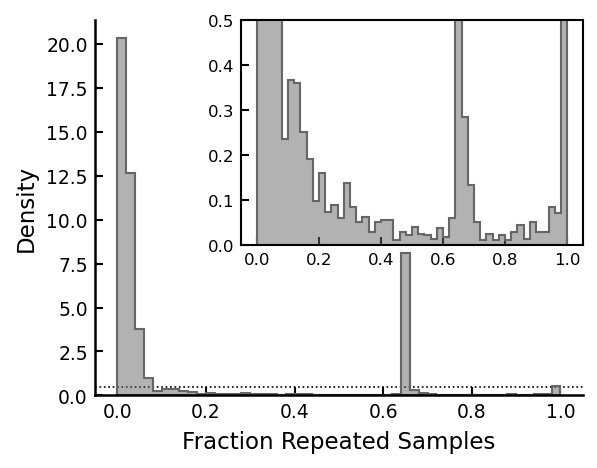

In [22]:
# Figure 2: Repeated samples independent of gaze representation
repeated_samples_plot_inset_all(tar_raw, inset_ylim=(0, 0.5))
for fmt in FIGTYPES:
    plt.savefig(os.path.join(folder_results, 'figure2.{:s}'.format(fmt)), 
               bbox_inches='tight', 
                dpi=300)

# Save 900dpi TIFF as requested by journal
plt.savefig(os.path.join(folder_results, 'figure-02.tif'), bbox_inches='tight', dpi=900)

In [23]:
# Number of trials in each histogram bin

# Cluster 1 - below 20 %
print(tar_raw.loc[tar_raw.repeated < 0.2, :].shape[0])
print(round(tar_raw.loc[tar_raw.repeated < 0.2, :].shape[0] / tar_raw.shape[0], 2))

# Cluster 1 - below 10 %
print(tar_raw.loc[tar_raw.repeated < 0.1, :].shape[0])
print(round(tar_raw.loc[tar_raw.repeated < 0.1, :].shape[0] / tar_raw.shape[0], 2))

10479
0.79
10191
0.77


In [24]:
# One eye missing
print(tar_raw.loc[tar_raw.outlier_reason == 'one_eye_missing', :].shape[0])
print(round(tar_raw.loc[tar_raw.outlier_reason == 'one_eye_missing', :].shape[0] / tar_raw.shape[0], 4))

tar_raw.loc[tar_raw.outlier_reason == 'one_eye_missing', :].vision.value_counts()

131
0.0098


glasses        56
contacts       50
uncorrected    25
Name: vision, dtype: int64

In [25]:
# Sampling error range
print(tar_raw.loc[tar_raw.outlier_reason == 'sampling_glitch', :].shape[0]) # Count
print(round(tar_raw.loc[tar_raw.outlier_reason == 'sampling_glitch', :].shape[0] / tar_raw.shape[0], 2)) # Proportion sampling errors
print(round(tar_raw.loc[tar_raw.outlier_reason == 'sampling_glitch', :].repeated.mean(), 2)) # Mean fraction of repeated samples

2280
0.17
0.65


## Metrics Histograms

Histograms are computed based on all fixations (before outlier correction using OUTLIER_ACC degrees). All further data analysis then uses the filtered data.

In [26]:
def annotate_percentile(ax, data, percentile, hist, dodgex, dodgey, color, fontsize=8, markersize=5):
    p = np.percentile(data, percentile)
    (vals, bins, patches) = hist
    
    y = np.argmin(np.abs(bins - p))
    scalex = ax.get_xlim()[1] * dodgex
    scaley = ax.get_ylim()[1] * dodgey

    ax.plot(p, vals[y] + scaley, 'v', color=color, markersize=markersize, markeredgecolor='k', markeredgewidth=0.5)
    ax.text(p + scalex, vals[y] + scaley, 'p{:d}: {:.2f}'.format(percentile, p), color='k', fontsize=fontsize, va='center', ha='left')

def annotate_mean(ax, data, hist, dodgex, dodgey, color='k', fontsize=8, markersize=5):
    p = np.mean(data)
    (vals, bins, patches) = hist

    y = np.argmin(np.abs(bins - p))
    scalex = ax.get_xlim()[1] * dodgex
    scaley = ax.get_ylim()[1] * dodgey

    ax.plot(p, vals[y] + scaley, 'v', color=color, markersize=markersize, markeredgecolor='k', markeredgewidth=0.5)
    ax.text(p + scalex, vals[y] + scaley, '$\mu$: {:.2f}'.format(p), color='k', fontsize=fontsize, va='center', ha='left')


In [27]:
def paper_figure_histograms_vert(val, figsize=(3.25, 6.0), steps=0.1, percentiles=True):
    """ Plot a histogram of all validation results """
    
    VERT_LINE_WIDTH = 0.8
    HIST_LINEWIDTH = 1.0
    PERC_COLOR = Set1_9.mpl_colors[1]
    PERC_SIZE= TICK_SIZE
    ALPHA = 0.4
    COLORS = [Set1_9.mpl_colors[1], Set1_9.mpl_colors[2]]
    DODGEX = 0.04
    
    ACC_VAR = 'acc'
    SD_VAR = 'sd'
    RMS_VAR = 'rmsi'
    
    ACC_RANGE = [0, 4]
    SD_RANGE = [0, 1.5]
    RMS_RANGE = [0, 1.0]
    BINS = 50

    fig, ax = plt.subplots(3, 1, figsize=figsize, dpi=150)
    
    # ACCURACY
    data = val.loc[:, ACC_VAR].sort_values().values

    hist = ax[0].hist(data,
               bins=BINS,
               range=ACC_RANGE,
               label='$\pm 15^\circ$',
               density=True,
               histtype='stepfilled',
               lw=HIST_LINEWIDTH,
               edgecolor=COLORS[0],
               facecolor=np.array(COLORS[0] + (ALPHA,)),
               zorder=2)

    y = ax[0].get_ylim()[1]
    
    if percentiles:
        annotate_percentile(ax[0], data, 95, hist, dodgex=DODGEX, dodgey=0.08, color='k')
        annotate_percentile(ax[0], data, 90, hist, dodgex=DODGEX, dodgey=0.08, color='k')
        annotate_percentile(ax[0], data, 50, hist, dodgex=DODGEX, dodgey=0.22, color='k')
        annotate_mean(ax[0], data, hist, dodgex=DODGEX, dodgey=0.1, color='k')

    ax[0].set_xlabel('Accuracy (Mean Error, °)', fontsize=LABEL_SIZE)
    
    # PRECISION SD
    sddata = val.loc[:, SD_VAR].values
    
    hist = ax[1].hist(sddata,
               bins=BINS,
               range=SD_RANGE,
               label='all targets',
               density=True,
               histtype='stepfilled',
               lw=HIST_LINEWIDTH,
               edgecolor=COLORS[0],
               facecolor=np.array(COLORS[0] + (ALPHA,)),
               zorder=2)

    y = ax[1].get_ylim()[1]

    if percentiles:
        annotate_percentile(ax[1], sddata, 95, hist, dodgex=DODGEX, dodgey=0.08, color='k')
        annotate_percentile(ax[1], sddata, 90, hist, dodgex=DODGEX, dodgey=0.09, color='k')
        annotate_percentile(ax[1], sddata, 50, hist, dodgex=DODGEX, dodgey=0.20, color='k')
        annotate_mean(ax[1], sddata, hist, dodgex=DODGEX, dodgey=0.11, color='k')
    
    ax[1].set_xlabel('SD Precision (°)', fontsize=LABEL_SIZE)
    
    # Precision RMS
    rmsdata = val.loc[:, RMS_VAR].values
    
    hist = ax[2].hist(rmsdata,
               bins=BINS,
               range=RMS_RANGE,
               label='$\pm 15^\circ$',
               density=True,
               histtype='stepfilled',
               lw=HIST_LINEWIDTH,
               edgecolor=COLORS[0],
               facecolor=np.array(COLORS[0] + (ALPHA,)),
               zorder=2)
    
    y = ax[2].get_ylim()[1]

    if percentiles:
        annotate_percentile(ax[2], rmsdata, 95, hist, dodgex=DODGEX, dodgey=0.06, color='k')
        annotate_percentile(ax[2], rmsdata, 90, hist, dodgex=DODGEX, dodgey=0.06, color='k')
        annotate_percentile(ax[2], rmsdata, 50, hist, dodgex=DODGEX, dodgey=0.22, color='k')
        annotate_mean(ax[2], rmsdata, hist, dodgex=DODGEX, dodgey=0.11, color='k')

    ax[2].set_xlabel('RMS Precision (°)', fontsize=LABEL_SIZE)
    
    for axx in ax:
        axx.set_ylabel('Density', fontsize=LABEL_SIZE)
        axx.tick_params(labelsize=TICK_SIZE, direction='in', width=1.0, length=4)
        axx.grid(False, which='major', axis='both')
        for axis in ['bottom','left']:
            axx.spines[axis].set_linewidth(1.2)
            axx.spines[axis].set_color('k')
        for axis in ['top','right']:
            axx.spines[axis].set_linewidth(0)

    plt.tight_layout()
    fig.align_ylabels()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.25)    


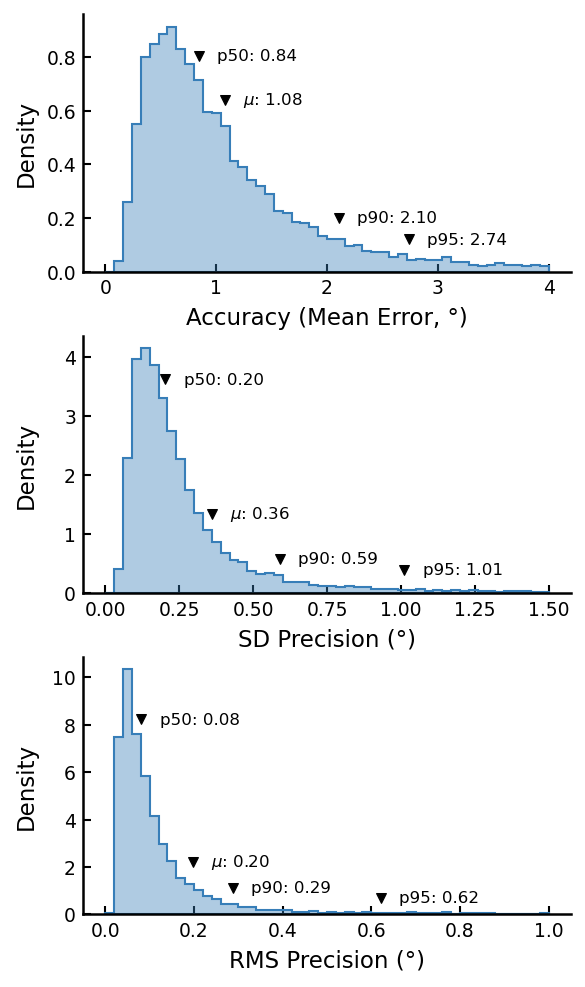

In [28]:
paper_figure_histograms_vert(tar)
for fmt in FIGTYPES:
    plt.savefig(os.path.join(folder_results, 'figure3.{:s}'.format(fmt)), 
               bbox_inches='tight', 
                dpi=300)

# Save 900dpi TIFF as requested by journal
plt.savefig(os.path.join(folder_results, 'figure-03.tif'), bbox_inches='tight', dpi=900)

## Summary Statistics

### Raw Data
Distribution ranges and percentiles reported in the Results section, computed by pooling all target fixations across individual participants.

In [29]:
PERCENTILES = [.25, .5, .75]

# Distribution summary, ALL target positions
print('All targets before outlier correction')
display(tar_raw.loc[:, ('acc', 'sd', 'rmsi')].describe(percentiles=PERCENTILES).T)

print('Inner +/- 10 degrees before outlier correction')
display(tar_raw_i10.loc[:, ('acc', 'sd', 'rmsi')].describe(percentiles=PERCENTILES).T)


All targets before outlier correction


,count,mean,std,min,25%,50%,75%,max
acc,13320.0,1.223832,1.390094,0.088480,0.545939,0.862877,1.410971,28.040375
sd,13320.0,0.432112,0.958807,0.032911,0.135501,0.207123,0.338300,29.129017
rmsi,13320.0,0.232333,0.638420,0.014375,0.050639,0.083285,0.149823,14.465610


Inner +/- 10 degrees before outlier correction


,count,mean,std,min,25%,50%,75%,max
acc,9000.0,1.064373,1.153679,0.088480,0.502948,0.781493,1.227216,28.040375
sd,9000.0,0.392780,0.894151,0.032911,0.129397,0.193202,0.309924,29.129017
rmsi,9000.0,0.217605,0.603745,0.014375,0.047287,0.076146,0.134868,9.423445


In [30]:
# Monocular data
print('Left and right eye (monocular data) before outlier correction')
display(tar_raw.loc[:, ('acc_L', 'sd_L', 'rmsi_L', 'acc_R', 'sd_R', 'rmsi_R')].describe(percentiles=PERCENTILES).T)


Left and right eye (monocular data) before outlier correction


,count,mean,std,min,25%,50%,75%,max
acc_L,13320.0,1.756103,2.099424,0.104869,0.693285,1.133253,1.978502,35.653131
sd_L,13320.0,0.570804,1.256266,0.000000,0.156463,0.241132,0.417025,29.301727
rmsi_L,13320.0,0.312423,0.918279,0.000000,0.059195,0.095208,0.178090,25.521893
acc_R,13320.0,1.733052,2.958428,0.121432,0.666396,1.045796,1.682380,53.374018
sd_R,13320.0,0.551318,1.297343,0.000000,0.152350,0.226862,0.375008,22.515561
rmsi_R,13320.0,0.299041,0.948513,0.000000,0.056493,0.088437,0.156149,21.666586


### After Outlier Correction

In [31]:
# Distribution summary, inner target positions (+/- 10 deg)
print('All targets after outlier correction')
display(tar.loc[:, ('acc', 'sd', 'rmsi')].describe(percentiles=PERCENTILES).T)

print('Inner +/- 10 degrees after outlier correction')
display(tar_i10.loc[:, ('acc', 'sd', 'rmsi')].describe(percentiles=PERCENTILES).T)


All targets after outlier correction


,count,mean,std,min,25%,50%,75%,max
acc,12952.0,1.077512,0.787265,0.088480,0.539024,0.843406,1.354060,4.989728
sd,12952.0,0.359534,0.641120,0.032911,0.134207,0.202457,0.323641,8.984426
rmsi,12952.0,0.196556,0.503240,0.014375,0.049949,0.081218,0.142754,8.850438


Inner +/- 10 degrees after outlier correction


,count,mean,std,min,25%,50%,75%,max
acc,8815.0,0.971955,0.714586,0.088480,0.498619,0.767838,1.196114,4.984482
sd,8815.0,0.342638,0.637530,0.032911,0.127980,0.191005,0.300764,8.309926
rmsi,8815.0,0.191636,0.512692,0.014375,0.046807,0.074860,0.130437,8.850438


In [32]:
print('Binocular and monocular data after outlier correction')
display(tar.loc[:, ('acc_L', 'acc_R', 'acc', 'sd_L', 'sd_R', 'sd', 'rmsi_L', 'rmsi_R', 'rmsi')].describe(percentiles=PERCENTILES).T)


Binocular and monocular data after outlier correction


,count,mean,std,min,25%,50%,75%,max
acc_L,12952.0,1.591485,1.569420,0.104869,0.684966,1.107481,1.896209,24.013298
acc_R,12952.0,1.449800,1.802130,0.121432,0.655876,1.020936,1.607504,45.345975
acc,12952.0,1.077512,0.787265,0.088480,0.539024,0.843406,1.354060,4.989728
sd_L,12952.0,0.511220,1.045413,0.038320,0.155460,0.237806,0.401918,25.889797
sd_R,12952.0,0.491899,1.113175,0.035296,0.152204,0.224591,0.362798,21.400573
sd,12952.0,0.359534,0.641120,0.032911,0.134207,0.202457,0.323641,8.984426
rmsi_L,12952.0,0.284977,0.820506,0.021603,0.058791,0.093387,0.170429,13.924331
rmsi_R,12952.0,0.275239,0.895386,0.017666,0.056486,0.087401,0.150596,21.666586
rmsi,12952.0,0.196556,0.503240,0.014375,0.049949,0.081218,0.142754,8.850438


In [33]:
print('Inner +/- 10 degrees after outlier correction - no vision correction')
display(tar_i10.loc[tar_raw.vision == 'uncorrected', ('acc', 'sd', 'rmsi')].describe(percentiles=PERCENTILES).T)

print('Inner +/- 10 degrees after outlier correction - contacts')
display(tar_i10.loc[tar_raw.vision == 'contacts', ('acc', 'sd', 'rmsi')].describe(percentiles=PERCENTILES).T)

print('Inner +/- 10 degrees after outlier correction - glasses')
display(tar_i10.loc[tar_raw.vision == 'glasses', ('acc', 'sd', 'rmsi')].describe(percentiles=PERCENTILES).T)


Inner +/- 10 degrees after outlier correction - no vision correction


,count,mean,std,min,25%,50%,75%,max
acc,2978.0,0.771362,0.532386,0.101606,0.418420,0.621669,0.964698,4.881910
sd,2978.0,0.251199,0.354398,0.032911,0.111968,0.162766,0.246836,4.327724
rmsi,2978.0,0.125725,0.272776,0.018370,0.042421,0.060783,0.095409,3.465649


Inner +/- 10 degrees after outlier correction - contacts


,count,mean,std,min,25%,50%,75%,max
acc,2960.0,0.849519,0.516097,0.106735,0.482988,0.736159,1.079414,4.369438
sd,2960.0,0.208873,0.236468,0.035050,0.118776,0.168033,0.241491,6.858739
rmsi,2960.0,0.090166,0.149258,0.014375,0.041307,0.062168,0.100709,3.509740


Inner +/- 10 degrees after outlier correction - glasses


,count,mean,std,min,25%,50%,75%,max
acc,2877.0,1.305558,0.910533,0.088480,0.666056,1.031015,1.644917,4.984482
sd,2877.0,0.574912,0.988451,0.042884,0.179461,0.274132,0.477015,8.309926
rmsi,2877.0,0.364257,0.812844,0.018679,0.071284,0.117474,0.221355,8.850438


## Prescription vs. Participant Metrics

This additional analysis tests whether a participant's prescription (in diopters) predicts their accuracy or precision metrics for the corresponding eye or for binocular gaze metrics. Only participants with prescription information (i.e., wearing glasses or contact lenses) were included in this analysis. 

In [34]:
# Aggregate left and right eye metrics within each participant
EYE_COLS = ['user', 'acc_L_valid', 'acc_R_valid', 'sd_L_valid', 'sd_R_valid', 'rmsi_L_valid', 'rmsi_R_valid',
           'acc_valid', 'sd_valid', 'rmsi_valid']
pp_eye = val.loc[:, EYE_COLS].groupby('user').agg([np.mean, np.std, np.min, np.max, np.ptp]).reset_index()

# Add demographic data
for var in ['gender', 'age', 'vision', 'prescriptionL', 'prescriptionR', 'hmd', 'IPDpp', 'dom_eye', 'setup']:
    for user in pp_eye.user.unique():
        pp_eye.loc[pp_eye.user == user, var] = val.loc[(val.user == user) & (val.session == 1), var].values[0]

# Keep only participants with prescription data
pp_eye = pp_eye.loc[pp_eye.prescriptionL != '', :]

In [35]:
# Left eye prescription -> left eye and binocular metrics
print('*Left Eye*')
for var in ['acc_L_valid', 'sd_L_valid', 'rmsi_L_valid', 'acc_valid', 'sd_valid', 'rmsi_valid']:
    
    slope, intercept, r_value, p_value, std_err = linregress(pp_eye.loc[:, ('prescriptionL', '')].astype(float).values, 
                                                             pp_eye.loc[:, (var, 'mean')].astype(float).values)
    print('{:s}: r={:.3f}, p={:.3f}, R²={:.3f}'.format(var, r_value, p_value, r_value**2))
                                                             

    
# Right eye prescription
print('\n*Right Eye*')
for var in ['acc_R_valid', 'sd_R_valid', 'rmsi_R_valid',  'acc_valid', 'sd_valid', 'rmsi_valid']:    
    slope, intercept, r_value, p_value, std_err = linregress(pp_eye.loc[:, ('prescriptionR', '')].astype(float).values, 
                                                             pp_eye.loc[:, (var, 'mean')].astype(float).values)
    print('{:s}: r={:.3f}, p={:.3f}, R²={:.3f}'.format(var, r_value, p_value, r_value**2))    

*Left Eye*
acc_L_valid: r=0.167, p=0.603, R²=0.028
sd_L_valid: r=0.402, p=0.196, R²=0.161
rmsi_L_valid: r=0.424, p=0.170, R²=0.180
acc_valid: r=0.315, p=0.319, R²=0.099
sd_valid: r=0.368, p=0.240, R²=0.135
rmsi_valid: r=0.369, p=0.238, R²=0.136

*Right Eye*
acc_R_valid: r=0.046, p=0.887, R²=0.002
sd_R_valid: r=0.006, p=0.986, R²=0.000
rmsi_R_valid: r=0.003, p=0.993, R²=0.000
acc_valid: r=0.155, p=0.629, R²=0.024
sd_valid: r=0.144, p=0.655, R²=0.021
rmsi_valid: r=0.188, p=0.559, R²=0.035
